<a href="https://colab.research.google.com/github/alexandertaoadams/AlexanderAdamsMastersThesis/blob/main/NB_EEG_Epilepsy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Classification: Epilepsy2

**URL to original dataset:**  
https://www.timeseriesclassification.com/description.php?Dataset=Epilepsy2

This notebook trains a **stochastic variational Gaussian Process** on the Epilepsy2 dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install gpjax
!pip install sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.2/488.2 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 142.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 31.7 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Uninstalling jaxlib-0.7.2:
      Successfully uninstalled jaxlib-0.7.2
  Attempting uninstall: jax
    Found existing installation: jax 0.7.2
    Uninstalling jax-0.7.2:
      Successfully uninstalled jax-0.7.2
  Attempting uninstall: flax
    Found existing installation: flax 0.10.7
    Uninstalling flax-0.10.7:
      Successfully uninstalled flax-0.10.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 57.0 MB/s eta 0:00:00
   ━━━━

In [3]:
# jax libraries
import numpy as np
import jax
import jax.numpy as jnp

# gpjax libraries
import gpjax as gpx

# core libraries
from flax import nnx
import optax as ox

# data manipulation and visualisation libraries
import pandas as pd
from sktime.datasets import load_from_tsfile
from matplotlib import pyplot as plt
import seaborn as sns

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [4]:
!git clone https://github.com/alexandertaoadams/AlexanderAdamsMastersThesis.git

import sys
sys.path.insert(0, '/content/AlexanderAdamsMastersThesis')
import AlexanderAdamsMastersThesis.src as src

from src.kernels import SignatureKernel
from src.inducing_variables import initial_inducing_variables
from src.utils import display_parameters, display_results, normalise

Cloning into 'AlexanderAdamsMastersThesis'...
remote: Enumerating objects: 302, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 302 (delta 70), reused 0 (delta 0), pack-reused 162 (from 1)
Receiving objects: 100% (302/302), 504.09 KiB | 5.66 MiB/s, done.
Resolving deltas: 100% (142/142), done.


### **Data Loading and Preprocessing**

In [6]:
file_path_train = "/content/drive/MyDrive/DATA_Epilepsy2/Epilepsy2_TRAIN.ts"
file_path_test = "/content/drive/MyDrive/DATA_Epilepsy2/Epilepsy2_TEST.ts"

train_data, train_labels = load_from_tsfile(file_path_train)
test_data, test_labels = load_from_tsfile(file_path_test)

In [7]:
train_data_2 = jnp.array((np.stack([np.stack(row) for row in train_data.to_numpy()])))
train_labels_2 = jnp.array([int(i) for i in train_labels])
xtrain, train_mean, train_std = normalise(train_data_2)
ytrain = train_labels_2

print(xtrain.shape)
print(ytrain.shape)
print(ytrain)

(80, 1, 178)
(80,)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1]


In [8]:
test_data_2 = jnp.array((np.stack([np.stack(row) for row in test_data.to_numpy()])))
test_labels_2 = jnp.array([int(i) for i in test_labels])
xtest = ((test_data_2 - train_mean) / (train_std))
ytest = test_labels_2

print(xtest.shape)
print(ytest.shape)
print(ytest)

(11420, 1, 178)
(11420,)
[0 0 0 ... 1 1 1]


### **Model Training**



In [9]:
# Initialising model
q_kernel = SignatureKernel(1, 178, 4)
q_mean_function = gpx.mean_functions.Constant()
q_prior = gpx.gps.Prior(mean_function=q_mean_function, kernel=q_kernel)
q_likelihood = gpx.likelihoods.Bernoulli(xtrain.shape[0])
q_posterior = q_likelihood * q_prior

# Create dataset, initialise inducing variables
D = gpx.dataset.Dataset(jnp.reshape(xtrain, (xtrain.shape[0], -1)), jnp.expand_dims(ytrain, axis=1))
Z = initial_inducing_variables(xtrain, ytrain, 8)

# Model
q = gpx.variational_families.VariationalGaussian(
    posterior=q_posterior,
    inducing_inputs=Z
)

/usr/local/lib/python3.12/dist-packages/gpjax/dataset.py:43: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/usr/local/lib/python3.12/dist-packages/gpjax/dataset.py:43: UserWarning: y is not of type float64.Got y.dtype=int32. This may lead to numerical instability.
  _check_precision(self.X, self.y)


In [10]:
# Training
optimised_model, history = gpx.fit(
    model=q,
    objective= lambda model, data: -gpx.objectives.elbo(model, data),
    train_data=D,
    optim=ox.adam(learning_rate=1e-3),
    trainable=gpx.parameters.Parameter,
    num_iters=1000,
    batch_size=80,
    verbose=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

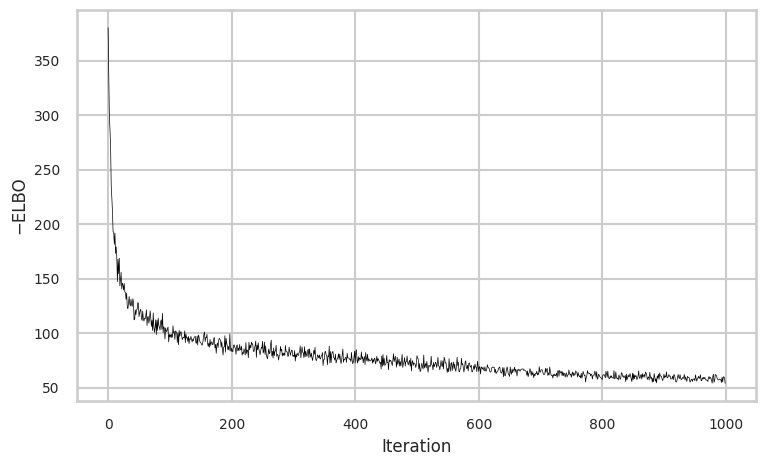

In [11]:
# Plot training process
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(8, 5))
plt.plot(history, color="black", linewidth=0.5, label="Training ELBO")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("−ELBO", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

In [12]:
# Display model hyperparameters
params = display_parameters(optimised_model)
params

,Parameter,Count,Values
0,Lengthscales,1,[1.4025713]
1,Amplitude,1,[0.9877261]
2,Weights,5,"[0.3919562, 0.98026407, 1.0804503, 0.91359997,..."


### **Model Evaluation**

In [13]:
@jax.jit
def predict_batch(model, batch):
    def predict_single(x):
        latent_dist = model.predict(x[None, :])
        predicted_dist = model.posterior.likelihood(latent_dist)
        return predicted_dist.mean.squeeze()
    return jax.vmap(predict_single)(batch)

def batched_predict(xtest, model, batch_size=90):
    num_points = xtest.shape[0]
    num_batches = (num_points + batch_size - 1) // batch_size

    results = []
    for i in range(num_batches):
        batch = xtest[i * batch_size : (i + 1) * batch_size]
        preds = predict_batch(model, batch)
        results.append(preds)

    return jnp.concatenate(results, axis=0)

In [14]:
# Get predicted means
predicted_mean = batched_predict(xtest, batch_size=100, model=optimised_model)
# Get predicted class labels (0 or 1)
predicted_labels = jnp.round(predicted_mean)

# print("Predicted means:", predicted_mean)
# print("Predicted labels:", predicted_labels)
# print("True labels:", ytest)

In [15]:
# Display results
results = display_results(predicted_labels, ytest)
results

,Value
Metric,
Test Size,11420.000
Negative Samples,2260.000
Postive Samples,9160.000
MCC,0.567
F1 score,0.924
Precision,0.894
Recall,0.956
